In [141]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [142]:
spark=SparkSession.builder\
    .master("local[*]")\
    .appName("Midterm")\
    .getOrCreate()
spark._jsc.hadoopConfiguration().set("google.cloud.auth.service.account.json.keyfile","/home/jovyan/work/flawless-shard-380118-6483865e92cb.json")

In [280]:
bucket_name="se413redditcommentsbucket"
path=f"gs://{bucket_name}/csv-reddit-comments/000000000033.csv"

In [281]:
df = spark.read\
.option("delimiter", ",")\
.option("multiline", "true")\
.option("quote", '"')\
 .option("header", "true")\
.option("escape", "\\")\
.option("escape", '"')\
.csv(path)

In [282]:
df = df.drop("score_hidden")
df = df.drop("archived")
df = df.drop("name")
df = df.drop("author_flair_text")
df = df.drop("downs")
df = df.drop("subreddit_id")
df = df.drop("link_id")
df = df.drop("retrieved_on")
df = df.drop("link_id")
df = df.drop("id")
df = df.drop("ups")
df = df.drop("distinguished")
df = df.drop("author_flair_css_class")

In [283]:
df = df.filter(df.body!='[deleted]')
df = df.filter(df.body!='[removed]')

In [284]:
df = df.filter(df.author!='[deleted]')
df = df.filter(df.author!='FanfictionBot')
df = df.filter(df.author!='SnapshillBot')
df = df.filter(df.author!='hit_bot')
df = df.filter(df.author!='Roboragi')

df = df.filter(df.author!='AutoModerator')
df = df.filter(df.author!='WritingPromptsRobot')

df = df.filter(df.author.rlike('(?!_bot)'))
df = df.filter(df.author.rlike('(?!_Bot)'))
df = df.filter(df.author.rlike('(?!Bot)'))
df = df.filter(df.author.rlike('(?!-Bot)'))
df = df.filter(df.author.rlike('(?!-bot)'))


In [285]:
df = df.filter(df.subreddit!='4chan4trump')
df = df.filter(df.subreddit!='testingground4bots')
df = df.filter(df.subreddit!='MemeEconomy')
df = df.filter(df.subreddit!='HPfanfiction')
df = df.filter(df.subreddit!='ParisComments')
df = df.filter(df.subreddit!='newsokuvip')
df = df.filter(df.subreddit!='kickopenthedoor')
df = df.filter(df.subreddit!='copypasta')
df = df.filter(df.subreddit!='AMAAggregator')

df = df.filter(df.subreddit!='ModerationLog')
df = df.filter(df.subreddit.rlike('(?!Aggregator)'))
df = df.filter(df.subreddit.rlike('(?!aggregator)'))
df = df.filter(df.subreddit.rlike('(?!log)'))
df = df.filter(df.subreddit.rlike('(?!Log)'))


In [286]:
(train_df,test_df) = df.randomSplit((0.2,0.8),seed=98)

In [256]:
stop_wrd_list = []
with open('/home/jovyan/work/pyspark-work/stopwords.txt', 'r') as file:
    for line in file:
        stop_wrd_list.append(line.strip())
print(stop_wrd_list)

['x', 'y', 'your', 'yours', 'yourself', 'yourselves', 'you', 'yond', 'yonder', 'yon', 'ye', 'yet', 'z', 'zillion', 'j', 'u', 'umpteen', 'usually', 'us', 'username', 'uponed', 'upons', 'uponing', 'upon', 'ups', 'upping', 'upped', 'up', 'unto', 'until', 'unless', 'unlike', 'unliker', 'unlikest', 'under', 'underneath', 'use', 'used', 'usedest', 'r', 'rath', 'rather', 'rathest', 'rathe', 're', 'relate', 'related', 'relatively', 'regarding', 'really', 'res', 'respecting', 'respectively', 'q', 'quite', 'que', 'qua', 'n', 'neither', 'neaths', 'neath', 'nethe', 'nethermost', 'necessary', 'necessariest', 'necessarier', 'never', 'nevertheless', 'nigh', 'nighest', 'nigher', 'nine', 'noone', 'nobody', 'nobodies', 'nowhere', 'nowheres', 'no', 'noes', 'nor', 'nos', 'no-one', 'none', 'not', 'notwithstanding', 'nothings', 'nothing', 'nathless', 'natheless', 't', 'ten', 'tills', 'till', 'tilled', 'tilling', 'to', 'towards', 'toward', 'towardest', 'towarder', 'together', 'too', 'thy', 'thyself', 'thus',

In [292]:
from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF
from pyspark.ml.feature import StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
import numpy as np 
import pandas as pd

In [293]:
tokenizer = Tokenizer(inputCol='body',outputCol='tokenized_body')
tokenize_result = tokenizer.transform(train_df)

In [294]:
stopwords_remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='filtered_body_tokens')
stopwords_remover.setStopWords(stop_wrd_list)

StopWordsRemover_59b82873eac8

In [295]:
result = stopwords_remover.transform(tokenize_result).show(10)

+--------------------+---------------+-----------+----------+-----+----------------+------+----------------+--------------------+--------------------+
|                body|         author|created_utc| parent_id|score|controversiality|gilded|       subreddit|      tokenized_body|filtered_body_tokens|
+--------------------+---------------+-----------+----------+-----+----------------+------+----------------+--------------------+--------------------+
|\n\n\n\n\n\n\n\n\...|       jivatman| 1573694257|t1_f7g35on|    2|               0|     0|    Conservative|[, , , , , , , , ...|[left-wing, blog,...|
|\n\n\n\n\n\n\n\nN...|    kettleman10| 1411809395|t1_cktsig6|    1|               0|     0|           anime|[, , , , , , , , ...|[gintama, makes, ...|
|\n\n\n\nI've adde...|ShockTrooper262| 1548471385| t3_ajvhr5|    4|               0|     0|ShitWehraboosSay|[, , , , i've, ad...|[i've, added, stu...|
|\n\n\n\nNice game...|    Spudmiester| 1534770541| t3_98q9g0|    3|               0|     0|   

In [296]:
vectorizer = CountVectorizer(inputCol='filtered_body_tokens',outputCol='body_features_raw')
idf = IDF(inputCol='body_features_raw',outputCol='vectorized_body_features')

In [299]:
numIterations = 2400
cost = np.zeros(10)
for k in range(2,4):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('vectorized_body_features').setMaxIter(numIterations)
    pipeline = Pipeline(stages=[tokenizer,stopwords_remover,vectorizer,idf,kmeans])
    kmeans_model = pipeline.fit(train_df)
    cost[k] = kmeans_model.stages[-1].summary.trainingCost

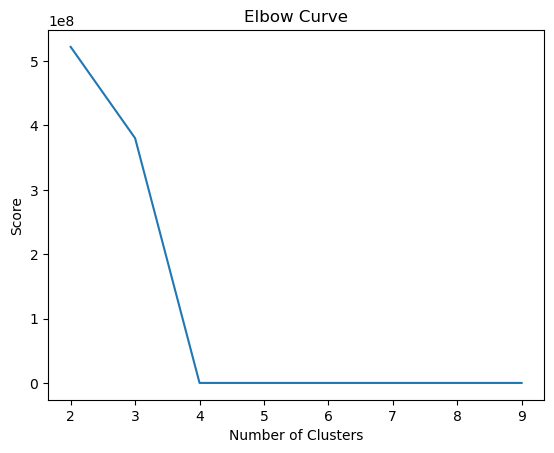

In [300]:
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [263]:
numIterations = 2000
numberClusters = 4
kmeans = KMeans(featuresCol='vectorized_body_features').setMaxIter(numIterations).setK(numberClusters).setSeed(13)

In [264]:
pipeline = Pipeline(stages=[tokenizer,stopwords_remover,vectorizer,idf,kmeans])

In [266]:
kmeans_model = pipeline.fit(train_df)

In [268]:
predictions = kmeans_model.transform(test_df)